In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
import altair as alt
import pandas as pd

from scipy.sparse import lil_matrix
from annoy import AnnoyIndex
from collections import defaultdict

from sklearn.decomposition import TruncatedSVD
from sklearn import manifold
from sklearn.decomposition import PCA

from sqlalchemy.dialects.postgresql import array_agg
from sqlalchemy.sql import functions as func

from osp_graphs.v1_db import session, Text, Field, Subfield, SubfieldDocument, Citation, Document

In [6]:
count = func.count(Citation.text_id)

res = (session
    .query(Text.surname, Text.title, array_agg(Citation.document_id))
    .join(Citation)
    .filter(Text.valid==True)
    .filter(Text.display==True)
    .group_by(Text.id)
    .order_by(count.desc())
    .limit(1000)
    .all())

In [7]:
surname_docs = defaultdict(set)
surname_titles = defaultdict(set)

for surname, title, doc_ids in res:
    key = surname.strip('.,').lower()
    surname_docs[key].update(doc_ids)
    surname_titles[key].add(title)

In [8]:
surnames = sorted(surname_docs.keys())
surname_to_idx = {s: i for i, s in enumerate(surnames)}

In [10]:
doc_ids = list(set([did for _, _, doc_ids in res for did in doc_ids]))
doc_id_to_idx = {did: i for i, did in enumerate(doc_ids)}

In [11]:
sdm = np.zeros((len(doc_ids), len(surnames)))

for surname in surnames:
    sidx = surname_to_idx[surname]
    for doc_id in surname_docs[surname]:
        didx = doc_id_to_idx[doc_id]
        sdm[didx][sidx] += 1

In [12]:
sdm.sum()

495788.0

In [13]:
svd = TruncatedSVD(n_components=10)

In [14]:
svd.fit(sdm)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=5,
       random_state=None, tol=0.0)

In [15]:
svd.components_.T.shape

(642, 10)

In [37]:
dr = manifold.TSNE(n_components=2, init='pca')

In [38]:
dr.fit_transform(svd.components_.T)

array([[-18.201788  ,  15.071253  ],
       [-15.359311  ,  18.70422   ],
       [  1.4442152 ,  -2.7904596 ],
       ...,
       [ 13.601753  ,  -1.8876991 ],
       [ -9.92569   , -22.931677  ],
       [ -0.92883986, -13.347915  ]], dtype=float32)

In [51]:
rows = []
for surname, (x, y) in zip(surnames, dr.embedding_):
    rows.append(dict(surname=surname, titles=surname_titles[surname], x=x, y=y))

In [52]:
df = pd.DataFrame(rows)

In [53]:
df.surname = df.surname.apply(lambda s: s.capitalize())

In [54]:
df.titles = df.titles.apply(lambda ts: ', '.join([t.strip(' /') for t in ts]))

In [55]:
df

,surname,titles,x,y
0,Abrams,"A glossary of literary terms, The Norton antho...",-18.201788,15.071253
1,Achebe,Things fall apart,-15.359311,18.704220
2,Addams,Twenty years at Hull-House;,1.444215,-2.790460
3,Adorno,THE CULTURE INDUSTRY,30.099222,7.738843
4,Aeschylus,"Eumenides, The libation bearers., Agamemnon,, ...",-21.131783,-1.438467
5,Aesop,Fables.,-12.977132,-0.322480
6,Alberts,"Essential cell biology, Molecular biology of t...",9.262084,-5.407114
7,Alcott,Little women,-8.325903,17.227570
8,Alexie,The Lone Ranger and Tonto fistfight in heaven,-4.135975,10.048624
9,Allen,Without feathers,-50.177563,-9.047170


In [56]:
chart = (alt
    .Chart(df, width=1000, height=700)
    .mark_circle()
    .encode(x='x', y='y', tooltip='titles')
    .mark_text()
    .encode(text='surname'))

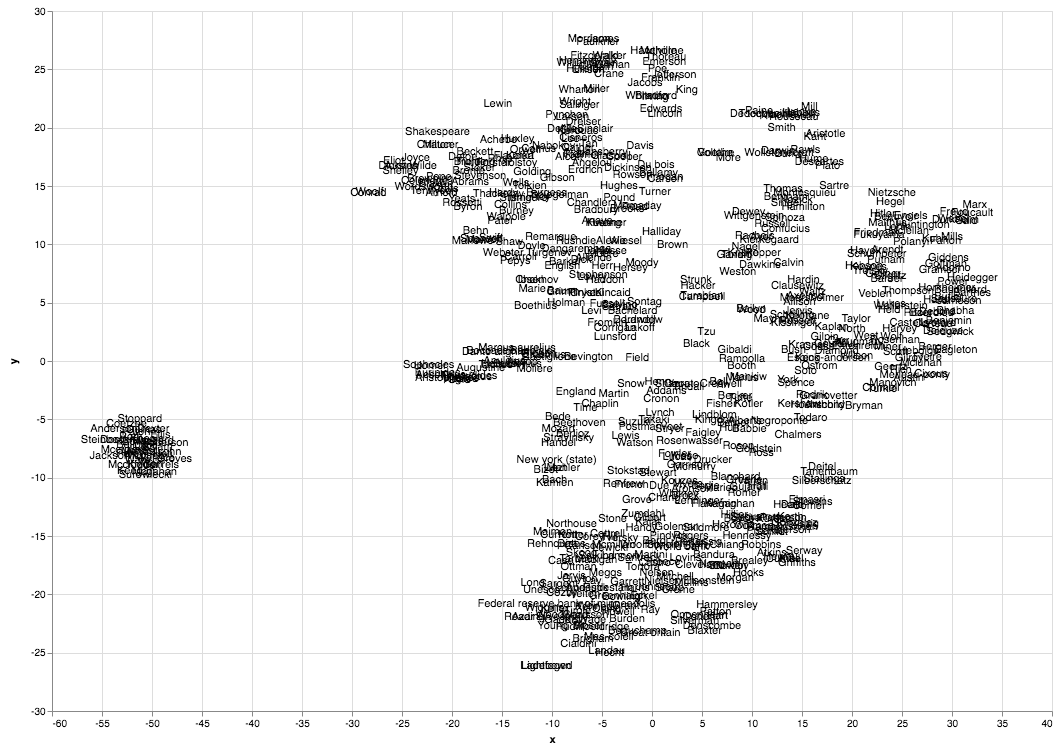

In [57]:
chart.interactive()